# 1) Setup & imports

In [1]:
import os, json, operator
from pathlib import Path
from dotenv import load_dotenv, find_dotenv
from langchain_community.document_loaders import TextLoader
from langchain_text_splitters import MarkdownHeaderTextSplitter
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain_community.vectorstores import Qdrant
from qdrant_client import QdrantClient
from qdrant_client.http.models import VectorParams, Distance
from langchain_qdrant import QdrantVectorStore
from typing import TypedDict, Annotated, Sequence, Literal
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage, BaseMessage
from langchain_core.runnables import RunnablePassthrough, RunnableParallel
from langchain_core.output_parsers import StrOutputParser, JsonOutputParser
from langfuse import Langfuse
from langfuse import get_client
from langfuse.langchain import CallbackHandler
from langgraph.graph import StateGraph, END, START
from langgraph.checkpoint.memory import MemorySaver

In [2]:
# Load environment variables from .env file
load_dotenv(find_dotenv(),override=True)

True

# 2) Document loading and vector stores

In [3]:
# Set up the embedding model using OpenAI embeddings with chunks for batch processing and smaller model (cost efficiency)
embeddings = OpenAIEmbeddings(model="text-embedding-3-small",chunk_size=10) 

# Chunk the document using the markdown header text splitter based on the structure of the document
headers_to_split_on = [
    ("#", "Header 1"),
    ("##", "Header 2"),
    ("###", "Header 3"),
]

md_splitter = MarkdownHeaderTextSplitter(headers_to_split_on, strip_headers=False)

# Create (or loads) a vector store using Chroma to store the embeddings with persistence
persist_dir = "../data/qdrant_db"

# Initialize Qdrant client with persistence
client = QdrantClient(path=persist_dir)

In [4]:
# Loads documents and creates persistent vectorstores
def create_or_load_vectorstore(file_name: str, collection_name: str):
    """
    Create or load a Qdrant vector store from a markdown file.
    
    Args:
        file_name: Path to the markdown file
        collection_name: Name of the Qdrant collection
        
    Returns:
        QdrantVectorStore instance
        
    Raises:
        FileNotFoundError: If the file doesn't exist
        ValueError: If the file is empty or collection name is invalid
        RuntimeError: For Qdrant-related errors
    """
    # Validate inputs
    if not collection_name or not collection_name.strip():
        raise ValueError("Collection name cannot be empty")
    
    if not file_name or not file_name.strip():
        raise ValueError("File name cannot be empty")
    
    # Check if file exists and read content
    file_path = Path(file_name)
    if not file_path.exists():
        raise FileNotFoundError(f"File not found: {file_name}")
    
    if not file_path.is_file():
        raise ValueError(f"Path is not a file: {file_name}")
    
    text = file_path.read_text(encoding="utf-8")
    if not text or not text.strip():
        raise ValueError(f"File is empty: {file_name}")
    
    # Split text into chunks
    chunks = md_splitter.split_text(text)
    if not chunks:
        raise ValueError(f"No chunks created from file: {file_name}")
    
    # Get existing collections
    collections = [c.name for c in client.get_collections().collections]
    
    # Load or create vector store
    if collection_name in collections:
        vectorstore = QdrantVectorStore(
            client=client,
            collection_name=collection_name,
            embedding=embeddings
        )
        count = client.count(collection_name=collection_name).count
        print(f"✓ Loaded existing vector store '{collection_name}' with {count} chunks")
    else:
        # Create collection
        client.create_collection(
            collection_name=collection_name,
            vectors_config=VectorParams(size=1536, distance=Distance.COSINE)
        )
        
        # Create vector store
        vectorstore = QdrantVectorStore(
            client=client,
            collection_name=collection_name,
            embedding=embeddings
        )
        
        # Add documents
        vectorstore.add_documents(chunks)
        count = client.count(collection_name=collection_name).count
        print(f"✓ Created new vector store '{collection_name}' with {count} chunks")
    
    return vectorstore


def load_all_agents(agents_dic):
    """
    Load all agent vector stores from a dictionary mapping collection names to file paths.
    
    Args:
        agents_dic: Dictionary with collection_name: file_path mappings
        
    Returns:
        Dictionary of successfully loaded vector stores
        
    Raises:
        ValueError: If agents_dic is empty or invalid
        RuntimeError: If no vector stores could be loaded
    """
    if not agents_dic:
        raise ValueError("agents_dic cannot be empty")
    
    if not isinstance(agents_dic, dict):
        raise ValueError("agents_dic must be a dictionary")
    
    vectorstores = {}
    errors = {}
    
    for collection_name, file_name in agents_dic.items():
        try:
            vectorstores[collection_name] = create_or_load_vectorstore(file_name, collection_name)
        except Exception as e:
            error_msg = f"Failed to load '{collection_name}' from '{file_name}': {e}"
            print(f"✗ {error_msg}")
            errors[collection_name] = str(e)
            # Continue processing other agents instead of failing completely
    
    # Report summary
    if vectorstores:
        print(f"\n✓ Successfully loaded {len(vectorstores)}/{len(agents_dic)} vector stores")
    
    if errors:
        print(f"✗ Failed to load {len(errors)} vector stores:")
        for name, error in errors.items():
            print(f"  - {name}: {error}")
    
    if not vectorstores:
        raise RuntimeError("Failed to load any vector stores")
    
    return vectorstores

In [5]:
# Define agent configuration - single source of truth
AGENT_CONFIG = {
    "HR": "../data/hr_agent_docs.md",
    "Tech": "../data/tech_agent_docs.md",
    "Commercial": "../data/commercial_agent_docs.md", 
    "Finance": "../data/finance_agent_docs.md"
}

# Load vectorstores using lowercase convention for collection names
agent_dic = {f"{name.lower()}_agent": path for name, path in AGENT_CONFIG.items()}
vectorstores = load_all_agents(agent_dic)

# Create reverse mapping: agent name -> vectorstore (for evaluator and routing)
agent_vectorstore_map = {
    name: vectorstores[f"{name.lower()}_agent"] 
    for name in AGENT_CONFIG.keys()
}

✓ Loaded existing vector store 'hr_agent' with 52 chunks
✓ Loaded existing vector store 'tech_agent' with 56 chunks
✓ Loaded existing vector store 'commercial_agent' with 52 chunks
✓ Loaded existing vector store 'finance_agent' with 52 chunks

✓ Successfully loaded 4/4 vector stores


# 3) Agent definition and other parameters

In [6]:
# Initialize LLMs with different temperatures and request timeouts
llm_deterministic = ChatOpenAI(
    model="gpt-4o-mini", 
    temperature=0,
    request_timeout=10  # 60 second timeout
)

llm_rag = ChatOpenAI(
    model="gpt-4o-mini", 
    temperature=0.3, # Using temperature=0.3 LLM to allow for more nuanced responses based on context
    request_timeout=10  # 60 second timeout
)

# Initialize Langfuse with enabled flag for easy toggling
LANGFUSE_ENABLED = True  # Set to False to disable temporarily

if LANGFUSE_ENABLED:
    Langfuse()
    langfuse_client = get_client()
    langfuse_handler = CallbackHandler()
else:
    # Create dummy handler that does nothing
    langfuse_client = None
    langfuse_handler = None
    print("⚠ Langfuse disabled for debugging")

In [7]:
# Define the state for the multi-agent system workflow using langgraph as recommended since langchain v1.0

class AgentState(TypedDict):
    """State for the multi-agent system workflow"""
    messages: Annotated[Sequence[BaseMessage], operator.add]
    current_query: str # The original user query
    intent: dict # The detected intent from the orchestrator
    agent_queries: dict  # Specific queries for each agent
    agent_responses: dict # Responses from each agent
    needs_clarification: bool # Whether clarification is needed
    final_response: str # The consolidated final response
    evaluation_scores: dict # Evaluation scores from the evaluator
    next_action: str # The next action to take

### 3.1) Prompts definition

In [8]:
# Intent classification prompt
INTENT_SYSTEM_PROMPT = """You are an intelligent query classifier for a SaaS company support system.

Analyze the user's query and determine:
1. If the query is clear enough to route, or if clarification is needed
2. Which specialized agents should handle the query

Available agents:
- HR: Payroll, vacation days, sick leave, benefits, employment policies
- Tech: Password resets, VPN, connectivity issues, software licenses, IT tickets
- Commercial: Pricing, plans, upgrades, downgrades, cancellations, billing
- Finance: Payment methods, invoice status, reimbursements, financial policies

Rules:
- If query is UNCLEAR or AMBIGUOUS: request clarification (make if brief and polite)
- If query is CLEAR: route to one or more appropriate agents
- Multiple agents can handle a single query if it spans domains

Respond in JSON format:
{{
  "action": "route" or "clarify",
  "agents": ["Agent1", "Agent2"] (if action is "route"),
  "clarification_message": "your question" (if action is "clarify")
}}"""

In [9]:
# Query decomposition prompt for multi-agent queries
QUERY_DECOMPOSITION_PROMPT = """You are a query decomposition expert. Given a user's question and a list of agents that should handle it, create specific, focused sub-questions for each agent.

Original Query: {original_query}
Agents to handle: {agents}

For each agent, create a clear, focused question that:
1. Extracts ONLY the relevant part of the original query for that agent's domain
2. Is self-contained and can be answered independently
3. Maintains the user's intent and context

Respond in JSON format:
{{
  "Agent1": "specific question for Agent1",
  "Agent2": "specific question for Agent2"
}}

Example:
Original: "I need to reset my VPN password and check my vacation balance"
Agents: ["Tech", "HR"]
Output: {{
  "Tech": "How do I reset my VPN password?",
  "HR": "How can I check my vacation balance?"
}}"""

In [10]:
# Response consolidation prompt
CONSOLIDATION_PROMPT = """You are a response consolidation expert.
Given a user's original query and responses from multiple specialized agents, create a single, coherent, well-organized response.

Original Query: {original_query}

Agent Responses:
{agent_responses}

Rules:
1. Be clear, concise and brief, maintaining polite and professional tone
2. Cover all parts of the user's original query
3. Distinguish between different topics when multiple agents responded
4. Remove any redundancy between agent responses
5. Preserve important details and escalation messages (as they are, not need to additional explanation)
6. Respond conversationally and directly to the user. Do NOT format as an email or letter.

Format the response clearly, using labels (example "[HR]", "[Tech]") if multiple topics are covered."""

In [11]:
# RAG prompt for specialized agents (now using creative LLM)
def create_rag_prompt(agent_type: str) -> ChatPromptTemplate:
    """Creates a RAG prompt for a specific agent type"""
    return ChatPromptTemplate.from_messages([
        ("system", f"""You are a specialized {agent_type} support agent.

Use ONLY the provided context to answer questions. 

Rules:
- Only use information from the context
- If context doesn't contain the answer, say "I don't have that information"
- Be concise but complete and helpful
- Maintain a professional, friendly tone
{"- If user wants to downgrade or cancel, include: 'This requires human assistance. Please contact support@company.com or call 1-800-SUPPORT.'" if agent_type == "Commercial" else ""}

Context: {{context}}"""),
        ("human", "{question}")
    ])

In [12]:
# Evaluation prompt with context
EVALUATION_PROMPT = """Evaluate this support agent response based on the provided context.

Query: {query}
Context Available to Agent:
{context}

Agent's Answer: {answer}

Evaluate the answer on a scale of 1-10 for each criterion:

1. RELEVANCE (1-10): Does the answer directly address the query?
   - 10: Perfectly addresses the query
   - 5: Partially addresses the query
   - 1: Completely irrelevant

2. COMPLETENESS (1-10): Is all necessary information from the context included?
   - 10: All relevant information from context is included
   - 5: Some key information is missing
   - 1: Major information gaps

3. ACCURACY (1-10): Is the answer factually correct based on the context?
   - 10: Completely accurate, no hallucinations
   - 5: Mostly accurate with minor errors
   - 1: Contains significant inaccuracies or hallucinations

4. GROUNDEDNESS (1-10): Does the answer avoid adding information NOT present in the context (no hallucinations)?
   - 10: Every claim is supported by the context
   - 5: Some claims lack context support
   - 1: Answer contains information not in context

Respond ONLY with JSON:
{{"relevance": <score>, "completeness": <score>, "accuracy": <score>, "groundedness": <score>}}"""

### 3.2) Creation of specialized RAG agents

In [13]:
# Similarity threshold for retrieval quality check
SIMILARITY_THRESHOLD = 0.7

# Reusable function to create RAG agents with similarity threshold validation
def create_rag_chain(vectorstore, agent_type: str):
    """
    Creates a modern RAG chain using LCEL with similarity threshold validation
    
    Args:
        vectorstore: The vector store to retrieve from
        agent_type: Type of agent (HR, Tech, Commercial, Finance)
    
    Returns:
        LCEL chain for RAG
    """
    
    retriever = vectorstore.as_retriever(
        search_type="similarity_score_threshold",
        search_kwargs={"k": 5, "score_threshold": SIMILARITY_THRESHOLD}
    )
    prompt = create_rag_prompt(agent_type)
    
    def format_docs(docs):
        """Format retrieved documents, return fallback if empty"""
        if not docs:
            return "No relevant information found in knowledge base."
        return "\n\n".join(doc.page_content for doc in docs)
    
    # Modern LCEL chain composition with creative LLM
    chain = (
        {
            "context": retriever | format_docs,
            "question": RunnablePassthrough()
        }
        | prompt
        | llm_rag  
        | StrOutputParser()
    )
    
    return chain

# Initialize all RAG agents using the global agent_vectorstore_map
rag_agents = {
    agent_name: create_rag_chain(vectorstore, agent_name)
    for agent_name, vectorstore in agent_vectorstore_map.items()
}

# 4) Orchestration and routing

### 4.1) Nodes

In [14]:
def orchestrator_node(state: AgentState) -> AgentState:
    """Classifies intent and creates focused queries for each agent"""
    
    query = state["current_query"]
    json_parser = JsonOutputParser()
    
    # Prepare callbacks config (handle None gracefully)
    callbacks = [langfuse_handler] if langfuse_handler else []
    
    # Step 1: Intent classification
    intent_chain = (
        ChatPromptTemplate.from_messages([
            ("system", INTENT_SYSTEM_PROMPT),
            ("human", "{query}")
        ])
        | llm_deterministic
        | json_parser
    )
    
    try:
        # Get intent
        intent_data = intent_chain.invoke(
            {"query": query},
            config={
                "callbacks": callbacks,
                "run_name": "intent_classification",
                "metadata": {"query": query}
            }
        )
        
        print(f"✓ Intent: {intent_data}")
        state["intent"] = intent_data
        
        # Check if clarification needed
        if intent_data.get("action") == "clarify":
            state["needs_clarification"] = True
            state["final_response"] = intent_data.get("clarification_message", 
                                                       "Could you please provide more details?")
            state["next_action"] = "end"
            return state
        
        # Step 2: Route to agents
        state["needs_clarification"] = False
        agents_to_call = intent_data.get("agents", [])
        print(f"✓ Routing to agents: {agents_to_call}")
        
        # If single agent, use original query
        if len(agents_to_call) == 1:
            state["agent_queries"] = {agents_to_call[0]: query}
            state["next_action"] = "route"
            print(f"✓ Single agent - using original query")
            return state
        
        # Step 3: Multi-agent decomposition
        if len(agents_to_call) > 1:
            try:
                decomposition_chain = (
                    ChatPromptTemplate.from_template(QUERY_DECOMPOSITION_PROMPT)
                    | llm_deterministic
                    | json_parser
                )
                
                agent_queries = decomposition_chain.invoke(
                    {
                        "original_query": query,
                        "agents": ", ".join(agents_to_call)
                    },
                    config={
                        "callbacks": callbacks,
                        "run_name": "query_decomposition",
                        "metadata": {"original_query": query, "agents": agents_to_call}
                    }
                )
                
                print(f"✓ Decomposed queries: {agent_queries}")
                state["agent_queries"] = agent_queries
                state["next_action"] = "route"
                
            except Exception as e:
                # Fallback: send original query to all agents
                print(f"⚠ Decomposition failed ({e}), using fallback")
                state["agent_queries"] = {agent: query for agent in agents_to_call}
                state["next_action"] = "route"
        
        return state
            
    except Exception as e:
        # Fallback for any errors
        print(f"✗ Orchestrator error: {e}")
        state["needs_clarification"] = True
        state["final_response"] = "I encountered an error. Could you please rephrase your question?"
        state["next_action"] = "end"
        return state

In [15]:
def routing_node(state: AgentState) -> AgentState:
    """Routes focused queries to appropriate agents for parallel execution"""
    
    agent_queries = state.get("agent_queries", {})
    
    # Prepare callbacks config (handle None gracefully)
    callbacks = [langfuse_handler] if langfuse_handler else []
    
    print(f"\n{'-'*60}")
    print(f"ROUTING: {len(agent_queries)} agent(s) to call")
    print(f"{'-'*60}")
    
    if not agent_queries:
        state["final_response"] = "I couldn't determine how to help. Please contact customer support."
        state["next_action"] = "consolidate"
        return state
    
    # Call each agent with its specific query
    responses = {}
    
    for agent_name, agent_query in agent_queries.items():
        print(f"\n[{agent_name}] Query: {agent_query[:80]}...")
        
        if agent_name not in rag_agents:
            print(f"✗ Agent '{agent_name}' not found in available agents: {list(rag_agents.keys())}")
            continue
            
        try:
            # Get agent response
            response = rag_agents[agent_name].invoke(
                agent_query,
                config={
                    "callbacks": callbacks,
                    "run_name": f"{agent_name.lower()}_agent_response",
                    "metadata": {
                        "agent": agent_name,
                        "query": agent_query
                    }
                }
            )
            responses[agent_name] = response
            print(f"✓ Response received ({len(response)} chars)")
            
        except Exception as e:
            print(f"✗ Error: {e}")
            responses[agent_name] = f"Error: {str(e)}"
    
    print(f"\n{'-'*60}")
    print(f"✓ Collected {len(responses)} response(s)")
    print(f"{'-'*60}\n")
    
    state["agent_responses"] = responses
    state["next_action"] = "consolidate"
    
    return state

In [16]:
def route_after_orchestrator(state: AgentState) -> Literal["routing", "evaluator"]:
    """Conditional routing after orchestrator"""
    return "evaluator" if state.get("needs_clarification") else "routing"

In [17]:
def consolidation_node(state: AgentState) -> AgentState:
    """Consolidates multiple agent responses into a single coherent response"""
    
    agent_responses = state.get("agent_responses", {})
    
    # Prepare callbacks config (handle None gracefully)
    callbacks = [langfuse_handler] if langfuse_handler else []
    
    if not agent_responses:
        state["final_response"] = "No responses were generated. Please contact customer support."
        state["next_action"] = "evaluate"
        return state
    
    # If only one agent responded, use its response directly
    if len(agent_responses) == 1:
        state["final_response"] = list(agent_responses.values())[0]
        state["next_action"] = "evaluate"
        return state
    
    # Multiple agents: consolidate using deterministic LLM
    try:
        # Format agent responses for the prompt
        formatted_responses = "\n\n".join([
            f"**{agent}**: {response}"
            for agent, response in agent_responses.items()
        ])
        
        consolidation_chain = (
            ChatPromptTemplate.from_template(CONSOLIDATION_PROMPT)
            | llm_deterministic  # temperature=0 for consistency
            | StrOutputParser()
        )
        
        consolidated_response = consolidation_chain.invoke(
            {
                "original_query": state["current_query"],
                "agent_responses": formatted_responses
            },
            config={
                "callbacks": callbacks,
                "run_name": "response_consolidation",
                "metadata": {
                    "original_query": state["current_query"],
                    "num_agents": len(agent_responses)
                }
            }
        )
        
        state["final_response"] = consolidated_response
        
    except Exception as e:
        # Log error to Langfuse if available
        error_msg = f"Consolidation error: {e}. Using simple concatenation."
        print(error_msg)
        
        if langfuse_handler and langfuse_client:
            try:
                trace_id = langfuse_handler.last_trace_id
                if trace_id:
                    langfuse_client.create_score(
                        trace_id=trace_id,
                        name="consolidation_error",
                        value=0,
                        data_type="NUMERIC",
                        comment=error_msg
                    )
            except:
                pass  # Ignore if Langfuse logging fails
        
        # Fallback to simple concatenation
        state["final_response"] = "\n\n".join([
            f"**{agent}**:\n{response}"
            for agent, response in agent_responses.items()
        ])
    
    state["next_action"] = "evaluate"
    return state

### 4.2 Evaluator node (BONUS)

In [18]:
def evaluator_node(state: AgentState) -> AgentState:
    """Evaluates individual agent responses and logs to Langfuse"""
    
    if state["needs_clarification"] or not state.get("agent_responses"):
        state["next_action"] = "end"
        return state
    
    query = state["current_query"]
    agent_queries = state.get("agent_queries", {})
    evaluation_scores = {}
    json_parser = JsonOutputParser()
    
    # Prepare callbacks config (handle None gracefully)
    callbacks = [langfuse_handler] if langfuse_handler else []
    
    # Create evaluation chain using deterministic LLM
    eval_chain = (
        ChatPromptTemplate.from_template(EVALUATION_PROMPT)
        | llm_deterministic
        | json_parser
    )
    
    for agent_name, answer in state["agent_responses"].items():
        try:
            # Retrieve fresh context for evaluation with similarity threshold
            context = "No context available"
            agent_query = agent_queries.get(agent_name, query)
            
            # Use global agent_vectorstore_map instead of local hardcoded mapping
            vectorstore = agent_vectorstore_map.get(agent_name)
            if vectorstore:
                retriever = vectorstore.as_retriever(
                    search_type="similarity_score_threshold",
                    search_kwargs={"k": 5, "score_threshold": SIMILARITY_THRESHOLD}
                )
                docs = retriever.invoke(agent_query)
                if docs:
                    context = "\n\n".join([doc.page_content for doc in docs])
                else:
                    context = "No relevant context found (similarity below threshold)"
            
            # Get evaluation scores (already a dict from JsonOutputParser)
            scores = eval_chain.invoke(
                {
                    "query": agent_query,
                    "context": context,
                    "answer": answer
                },
                config={
                    "callbacks": callbacks,
                    "run_name": f"evaluation_{agent_name.lower()}",
                    "metadata": {
                        "agent": agent_name,
                        "evaluation_type": "rag_quality_with_context"
                    }
                }
            )
            
            # Calculate overall score
            overall = sum(scores.values()) / len(scores)
            scores["overall"] = round(overall, 2)
            
            # Add scores to Langfuse if available
            if langfuse_handler and langfuse_client:
                try:
                    trace_id = langfuse_handler.last_trace_id
                    if trace_id:
                        for criterion, score_value in scores.items():
                            langfuse_client.create_score(
                                trace_id=trace_id,
                                name=f"{agent_name}_{criterion}",
                                value=score_value,
                                data_type="NUMERIC"
                            )
                except Exception as e:
                    print(f"⚠ Langfuse score logging failed for {agent_name}: {e}")
            
            evaluation_scores[agent_name] = scores
            
        except Exception as e:
            print(f"Evaluation error for {agent_name}: {e}")
            evaluation_scores[agent_name] = {"error": str(e)}
    
    state["evaluation_scores"] = evaluation_scores
    state["next_action"] = "end"
    
    return state

### 4.3) Building agents workflow (using LangGraph)

In [19]:
# Create the graph with memory
workflow = StateGraph(AgentState)
memory = MemorySaver()

# Add nodes (semicolons suppress Jupyter output)
workflow.add_node("orchestrator", orchestrator_node);
workflow.add_node("routing", routing_node);
workflow.add_node("consolidation", consolidation_node);
workflow.add_node("evaluator", evaluator_node);

# Define edges
workflow.add_edge(START, "orchestrator")
workflow.add_conditional_edges(
    "orchestrator",
    route_after_orchestrator,
    {
        "routing": "routing",
        "evaluator": "evaluator"
    }
)
workflow.add_edge("routing", "consolidation")  # Route to consolidation first
workflow.add_edge("consolidation", "evaluator")  # Then to evaluator
workflow.add_edge("evaluator", END)

# Compile the graph
app = workflow.compile(checkpointer=memory)

### 4.4) Process queries

In [20]:
def process_query(query: str, conversation_id: str = "default", verbose: bool = True):
    """
    Process a user query through the multi-agent system
    
    Args:
        query: User's question
        conversation_id: Unique ID for conversation tracking
        verbose: If True, print detailed agent responses
        
    Returns:
        Dictionary with response and metadata
    """
    
    # Initialize state
    initial_state = {
        "messages": [HumanMessage(content=query)],
        "current_query": query,
        "intent": {},
        "agent_queries": {},
        "agent_responses": {},
        "needs_clarification": False,
        "final_response": "",
        "evaluation_scores": {},
        "next_action": ""
    }
    
    # Configure with conversation ID
    config = {"configurable": {"thread_id": conversation_id}}
    
    # Run the workflow
    result = app.invoke(initial_state, config=config)
    
    # Print detailed breakdown if verbose
    if verbose and result.get("agent_responses"):
        print("\n" + "-"*80)
        print("INDIVIDUAL AGENT RESPONSES:")
        print("-"*80)
        
        agent_queries = result.get("agent_queries", {})
        for agent_name, response in result["agent_responses"].items():
            agent_query = agent_queries.get(agent_name, query)
            print(f"\n[{agent_name} Agent]")
            print(f"Query: {agent_query}")
            print(f"Response: {response}")
            print("-" * 80)
    
    return {
        "query": query,
        "intent": result.get("intent", {}),
        "agent_queries": result.get("agent_queries", {}),
        "agent_responses": result.get("agent_responses", {}),
        "final_response": result["final_response"],
        "agents_used": list(result.get("agent_responses", {}).keys()),
        "evaluation_scores": result.get("evaluation_scores", {}),
        "needs_clarification": result["needs_clarification"],
        "conversation_id": conversation_id
    }

### 4.5) Visualization

In [21]:
def visualize_workflow():
    """Generate a visualization of the workflow"""
    try:
        from IPython.display import Image, display
        display(Image(app.get_graph().draw_mermaid_png()))
    except Exception as e:
        print(f"Visualization requires mermaid: {e}")
        print("\nWorkflow structure:")
        print("START → orchestrator → [routing OR evaluator] → consolidation → evaluator → END")

WORKFLOW VISUALIZATION


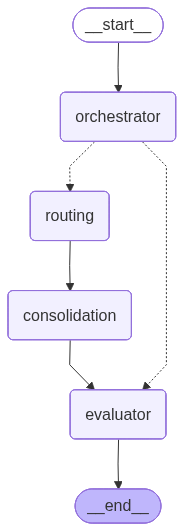

In [22]:
# Visualize workflow
print("=" * 80)
print("WORKFLOW VISUALIZATION")
print("=" * 80)
visualize_workflow()

# 5) Testing & Examples

In [23]:
# Reusable function to print tests and examples
def print_test_example(description: str, query: str, verbose: bool = True):
    """Prints the test example description and query"""
    print("=" * 80)
    print(description)
    print("=" * 80)
    result = process_query(query=query, verbose=verbose)
    print(f"\n{'='*80}")
    print("FINAL RESPONSE:")
    print("="*80)
    print(result['final_response'])
    print(f"\nEvaluation Scores: {result['evaluation_scores']}")
    print()

In [55]:
# Test Case 1: Simple HR query (single agent)
print_test_example(
    description="Test Case 1: Simple HR Query (Single Agent)",
    query="What is the vacation policy?",
    verbose=True
)

Test Case 1: Simple HR Query (Single Agent)
✓ Intent: {'action': 'route', 'agents': ['HR']}
✓ Routing to agents: ['HR']
✓ Single agent - using original query

------------------------------------------------------------
ROUTING: 1 agent(s) to call
------------------------------------------------------------

[HR] Query: What is the vacation policy?...
✓ Response received (279 chars)

------------------------------------------------------------
✓ Collected 1 response(s)
------------------------------------------------------------


--------------------------------------------------------------------------------
INDIVIDUAL AGENT RESPONSES:
--------------------------------------------------------------------------------

[HR Agent]
Query: What is the vacation policy?
Response: To request vacation, use the HR portal by navigating to My Time > Request PTO. Select your desired dates, choose “Vacation,” optionally add a note, and submit the request. Your manager will receive an approval task,

In [56]:
# Test Case 2: Simple Tech query (single agent)
print_test_example(
    description="Test Case 2: Simple Tech Query (Single Agent)",
    query="How do I connect to the VPN?",
    verbose=True
)

Test Case 2: Simple Tech Query (Single Agent)
✓ Intent: {'action': 'route', 'agents': ['Tech']}
✓ Routing to agents: ['Tech']
✓ Single agent - using original query

------------------------------------------------------------
ROUTING: 1 agent(s) to call
------------------------------------------------------------

[Tech] Query: How do I connect to the VPN?...
✓ Response received (214 chars)

------------------------------------------------------------
✓ Collected 1 response(s)
------------------------------------------------------------


--------------------------------------------------------------------------------
INDIVIDUAL AGENT RESPONSES:
--------------------------------------------------------------------------------

[Tech Agent]
Query: How do I connect to the VPN?
Response: To connect to the company VPN, install the VPN client from the IT portal. Use your company credentials and select the “Corporate” profile. If you encounter repeated disconnections, please contact IT for as

In [57]:
# Test Case 3: Simple Finance query (single agent)
print_test_example(
    description="Test Case 3: Simple Finance Query (Single Agent)",
    query="What are the travel reimbursement limits?",
    verbose=True
)

Test Case 3: Simple Finance Query (Single Agent)
✓ Intent: {'action': 'route', 'agents': ['Finance']}
✓ Routing to agents: ['Finance']
✓ Single agent - using original query

------------------------------------------------------------
ROUTING: 1 agent(s) to call
------------------------------------------------------------

[Finance] Query: What are the travel reimbursement limits?...
✓ Response received (144 chars)

------------------------------------------------------------
✓ Collected 1 response(s)
------------------------------------------------------------


--------------------------------------------------------------------------------
INDIVIDUAL AGENT RESPONSES:
--------------------------------------------------------------------------------

[Finance Agent]
Query: What are the travel reimbursement limits?
Response: Meals are reimbursed up to BRL 150 per day. Travel expenses must comply with the company travel policy, and exceptions require Finance approval.
-------------------

In [58]:
# Test Case 4: Simple Commercial query (single agent and without escalation)
print_test_example(
    description="Test Case 4: Simple Commercial Query (single agent and without Escalation)",
    query="How can I get a discount on my subscription plan?",
    verbose=True
)

Test Case 4: Simple Commercial Query (single agent and without Escalation)
✓ Intent: {'action': 'route', 'agents': ['Commercial']}
✓ Routing to agents: ['Commercial']
✓ Single agent - using original query

------------------------------------------------------------
ROUTING: 1 agent(s) to call
------------------------------------------------------------

[Commercial] Query: How can I get a discount on my subscription plan?...
✓ Response received (156 chars)

------------------------------------------------------------
✓ Collected 1 response(s)
------------------------------------------------------------


--------------------------------------------------------------------------------
INDIVIDUAL AGENT RESPONSES:
--------------------------------------------------------------------------------

[Commercial Agent]
Query: How can I get a discount on my subscription plan?
Response: You may qualify for a discount if you have a contract with more than 100 users or if you are a non-profit orga

In [59]:
# Test Case 5: Multi-domain query (multiple agents with decomposition)
print_test_example(
    description="Test Case 5: Multi-Domain Query (Multiple Agents)",
    query="I need to reset my password and schedule my vacations.",
    verbose=True
)

Test Case 5: Multi-Domain Query (Multiple Agents)
✓ Intent: {'action': 'route', 'agents': ['Tech', 'HR']}
✓ Routing to agents: ['Tech', 'HR']
✓ Decomposed queries: {'Tech': 'How do I reset my password?', 'HR': 'How can I schedule my vacations?'}

------------------------------------------------------------
ROUTING: 2 agent(s) to call
------------------------------------------------------------

[Tech] Query: How do I reset my password?...
✓ Response received (162 chars)

[HR] Query: How can I schedule my vacations?...
✓ Response received (298 chars)

------------------------------------------------------------
✓ Collected 2 response(s)
------------------------------------------------------------


--------------------------------------------------------------------------------
INDIVIDUAL AGENT RESPONSES:
--------------------------------------------------------------------------------

[Tech Agent]
Query: How do I reset my password?
Response: You can reset your password by visiting the 

In [60]:
# Test Case 6: Unclear query needing clarification
print_test_example(
    description="Test Case 6: Unclear Query (Needs Clarification)",
    query="I have a problem",
    verbose=False
)

Test Case 6: Unclear Query (Needs Clarification)
✓ Intent: {'action': 'clarify', 'clarification_message': "Could you please provide more details about the problem you're experiencing?"}

FINAL RESPONSE:
Could you please provide more details about the problem you're experiencing?

Evaluation Scores: {}



In [25]:
# Test Case 7: Commercial query with escalation
print_test_example(
    description="Test Case 7: Commercial Query (with Escalation)",
    query="I want to cancel my subscription",
    verbose=False
)

Test Case 7: Commercial Query (with Escalation)
✓ Intent: {'action': 'route', 'agents': ['Commercial']}
✓ Routing to agents: ['Commercial']
✓ Single agent - using original query

------------------------------------------------------------
ROUTING: 1 agent(s) to call
------------------------------------------------------------

[Commercial] Query: I want to cancel my subscription...
✓ Response received (89 chars)

------------------------------------------------------------
✓ Collected 1 response(s)
------------------------------------------------------------


FINAL RESPONSE:
This requires human assistance. Please contact support@company.com or call 1-800-SUPPORT.

Evaluation Scores: {'Commercial': {'relevance': 5, 'completeness': 5, 'accuracy': 5, 'groundedness': 5, 'overall': 5.0}}



In [ ]:
# Test Case 8: Complex multi-domain query
# Note: This test makes 9 LLM calls - may take 30-60 seconds
print_test_example(
    description="Test Case 8: Complex Multi-Domain Query",
    query=(
        "I need help with three things: updating my payroll information, request a software license, "
        "and understanding the pricing for upgrading my plan."
    ),
    verbose=True
)


Test Case 8: Complex Multi-Domain Query
✓ Intent: {'action': 'route', 'agents': ['HR', 'Tech', 'Commercial']}
✓ Routing to agents: ['HR', 'Tech', 'Commercial']
✓ Decomposed queries: {'HR': 'How can I update my payroll information?', 'Tech': 'How do I request a software license?', 'Commercial': 'What is the pricing for upgrading my plan?'}

------------------------------------------------------------
ROUTING: 3 agent(s) to call
------------------------------------------------------------

[HR] Query: How can I update my payroll information?...
✓ Response received (300 chars)

[Tech] Query: How do I request a software license?...
✓ Response received (259 chars)

[Commercial] Query: What is the pricing for upgrading my plan?...
✓ Response received (192 chars)

------------------------------------------------------------
✓ Collected 3 response(s)
------------------------------------------------------------


--------------------------------------------------------------------------------
I

In [27]:
# Test Case 9: Complex multi-domain query without information in context
print_test_example(
    description="Test Case 9: Complex Multi-Domain Query (No Info in Context)",
    query="I need to reset my VPN password, check how many vacation days I have and how to get a loan?",
    verbose=True
)

Test Case 9: Complex Multi-Domain Query (No Info in Context)
✓ Intent: {'action': 'route', 'agents': ['Tech', 'HR', 'Finance']}
✓ Routing to agents: ['Tech', 'HR', 'Finance']
✓ Decomposed queries: {'Tech': 'How do I reset my VPN password?', 'HR': 'How can I check how many vacation days I have?', 'Finance': 'What are the steps to apply for a loan?'}

------------------------------------------------------------
ROUTING: 3 agent(s) to call
------------------------------------------------------------

[Tech] Query: How do I reset my VPN password?...
✓ Response received (30 chars)

[HR] Query: How can I check how many vacation days I have?...
✓ Response received (30 chars)

[Finance] Query: What are the steps to apply for a loan?...


No relevant docs were retrieved using the relevance score threshold 0.7


✓ Response received (30 chars)

------------------------------------------------------------
✓ Collected 3 response(s)
------------------------------------------------------------



No relevant docs were retrieved using the relevance score threshold 0.7



--------------------------------------------------------------------------------
INDIVIDUAL AGENT RESPONSES:
--------------------------------------------------------------------------------

[Tech Agent]
Query: How do I reset my VPN password?
Response: I don't have that information.
--------------------------------------------------------------------------------

[HR Agent]
Query: How can I check how many vacation days I have?
Response: I don't have that information.
--------------------------------------------------------------------------------

[Finance Agent]
Query: What are the steps to apply for a loan?
Response: I don't have that information.
--------------------------------------------------------------------------------

FINAL RESPONSE:
To address your queries:

[Tech] For resetting your VPN password, please refer to your IT department or the VPN provider's support resources, as I don't have that information.

[HR] Regarding your vacation days, I recommend checking with your 

In [29]:
# Test Case 10: Query outside all domains
print_test_example(
    description="Test Case 10: Query Outside All Domains",
    query="Can you tell me about the company's history?",
    verbose=True
)

Test Case 10: Query Outside All Domains
✓ Intent: {'action': 'clarify', 'clarification_message': "Could you please specify if you're looking for information related to HR, commercial aspects, or something else?"}

FINAL RESPONSE:
Could you please specify if you're looking for information related to HR, commercial aspects, or something else?

Evaluation Scores: {}



In [30]:
# Test Case 11: Broad multi-agent query
print_test_example(
    description="Test Case 11: Broad Multi-Agent Query",
    query="How do payments work?",
    verbose=True
)

Test Case 11: Broad Multi-Agent Query
✓ Intent: {'action': 'clarify', 'clarification_message': "Could you please specify if you're asking about payment methods, invoice status, or something else related to payments?"}

FINAL RESPONSE:
Could you please specify if you're asking about payment methods, invoice status, or something else related to payments?

Evaluation Scores: {}



In [31]:
# Test Case 12: Multiple requests from SAME domain (edge case)
print_test_example(
    description="Test Case 12: Multiple Requests from Same Domain",
    query="How do I request vacation AND submit a sick leave note?",
    verbose=True
)

Test Case 12: Multiple Requests from Same Domain
✓ Intent: {'action': 'route', 'agents': ['HR']}
✓ Routing to agents: ['HR']
✓ Single agent - using original query

------------------------------------------------------------
ROUTING: 1 agent(s) to call
------------------------------------------------------------

[HR] Query: How do I request vacation AND submit a sick leave note?...
✓ Response received (445 chars)

------------------------------------------------------------
✓ Collected 1 response(s)
------------------------------------------------------------


--------------------------------------------------------------------------------
INDIVIDUAL AGENT RESPONSES:
--------------------------------------------------------------------------------

[HR Agent]
Query: How do I request vacation AND submit a sick leave note?
Response: To request vacation, use the HR portal: My Time > Request PTO. Select your dates, choose “Vacation,” add an optional note, and submit. Your manager will rec

In [25]:
# Test Case 13: Partially clear, partially unclear query (edge case)
print_test_example(
    description="Test Case 13: Partially Clear/Unclear Query",
    query="I need help with VPN and also something else that's not working",
    verbose=True
)

Test Case 13: Partially Clear/Unclear Query
✓ Intent: {'action': 'clarify', 'clarification_message': "Could you please specify what 'something else' refers to? This will help us route your query correctly."}

FINAL RESPONSE:
Could you please specify what 'something else' refers to? This will help us route your query correctly.

Evaluation Scores: {}



In [26]:
# Test Case 14: Query with conflicting/contradictory requests (edge case)
print_test_example(
    description="Test Case 14: Conflicting Request",
    query="I want to upgrade to Enterprise plan and also cancel my subscription",
    verbose=True
)

Test Case 14: Conflicting Request
✓ Intent: {'action': 'route', 'agents': ['Commercial']}
✓ Routing to agents: ['Commercial']
✓ Single agent - using original query

------------------------------------------------------------
ROUTING: 1 agent(s) to call
------------------------------------------------------------

[Commercial] Query: I want to upgrade to Enterprise plan and also cancel my subscription...
✓ Response received (289 chars)

------------------------------------------------------------
✓ Collected 1 response(s)
------------------------------------------------------------


--------------------------------------------------------------------------------
INDIVIDUAL AGENT RESPONSES:
--------------------------------------------------------------------------------

[Commercial Agent]
Query: I want to upgrade to Enterprise plan and also cancel my subscription
Response: To upgrade to the Enterprise plan, log into the customer portal, navigate to “Manage Subscription,” and select th

# 6) Langfuse integration

Langfuse integration running via langchaing integration in workflows/chains.

# Shutdown and cleanup

In [31]:
def shutdown_resources():
    """
    Properly shutdown all resources
    """
    # Close Qdrant client
    if client:
        client.close()
        print("✓ Qdrant client closed successfully")
    
    # Flush and shutdown Langfuse if enabled
    if langfuse_client:
        langfuse_client.flush()
        langfuse_client.shutdown()
        print("✓ Langfuse flushed and shutdown successfully")
    else:
        print("⚠ Langfuse was disabled, skipping shutdown")

shutdown_resources()

✓ Qdrant client closed successfully
✓ Langfuse flushed and shutdown successfully


In [ ]:
# # After test completes
# try:
#     langfuse_client.flush()
#     print("✓ Langfuse flushed")
# except Exception as e:
#     print(f"⚠ Langfuse flush warning: {e}")

✓ Langfuse flushed
